In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy
import ipynb.fs
import pandas as pd

from ipynb.fs.defs.BCI_COMP_IV_functions import (extractInfo, featureExtraction, createFilterBank,
                                                testWindowLength, testClassifier, testFrequencyBand,
                                                testWindowStartTime,testWindowStartTime_Length, startRunningClassifier,
                                                tuneModelHyperParams)


In [2]:
dataA = scipy.io.loadmat("BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1a_1000Hz.mat")

dataA["cnt"] = 0.1 * dataA["cnt"].astype(float)

eeg = dataA["cnt"].T
nChannels, nSamples = eeg.shape

calibDataStore, testData_motionIntent, _, comp = featureExtraction(dataA,0.7)

calibData_idle_motionIntent, testData_idle_motionIntent, W_idle_motionIntent , comp = featureExtraction(dataA,0.7,ExtractionType="idle_motionIntent")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Base Classifiers for detecting Idle State (no resampling)

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve, auc


ldaModel = LDA()
SVMmodel = SVC(probability=True,class_weight="balanced")
logRegModel = LogisticRegression(class_weight="balanced")


In [4]:
nCols = len(calibData_idle_motionIntent.columns)


print("LDA: ",np.mean(cross_val_score(ldaModel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("SVM: ",np.mean(cross_val_score(SVMmodel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print()


LDA:  0.5642857142857143
Logistic Regression:  0.5535714285714286
SVM:  0.5607142857142857



### Tuning Classifiers for detecting Idle State (no resampling)


In [5]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [6]:
bestMods = tuneModelHyperParams(calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],testData_idle_motionIntent.iloc[:,:nCols-1], testData_idle_motionIntent.iloc[:,nCols-1])
bestMods

defaultdict(dict,
            {'accuracy': {'SVC': (SVC(C=1000, class_weight='balanced', gamma=1, probability=True),
               0.49166666666666664),
              'LogReg': (LogisticRegression(C=0.1206792640639329, class_weight='balanced',
                                  solver='liblinear'),
               0.6083333333333333),
              'LDA': (LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr'),
               0.5916666666666667)},
             'roc_auc': {'SVC': (SVC(C=1000, class_weight='balanced', gamma=1, probability=True),
               0.49166666666666664),
              'LogReg': (LogisticRegression(C=0.09102981779915217, solver='liblinear'),
               0.5916666666666667),
              'LDA': (LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr'),
               0.5916666666666667)},
             'f1': {'SVC': (SVC(C=10, class_weight='balanced', gamma=0.001, probability=True),
               0.49166666666666664),
              'LogReg': (LogisticRegres

In [7]:
bestModel, bestPerformance = None, 0

for metric in bestMods:
    for model in bestMods[metric]:
        mod, perf = bestMods[metric][model]

        if perf > bestPerformance:
            bestModel, bestPerformance = mod, perf


In [8]:

print(bestModel, bestPerformance)


LogisticRegression(C=0.1206792640639329, class_weight='balanced',
                   solver='liblinear') 0.6083333333333333


In [9]:
idlesStateClassifier = bestModel

### Base Classifier for classifying motion intent signals

In [10]:

ldaModel = LDA()
SVMmodel = SVC(probability=True)
logRegModel = LogisticRegression()


In [11]:
for name, calibData in calibDataStore.items():

    nCols = len(calibData.columns)
    print(name,end="\n")
    print("-----------")

    print("LDA: ",np.mean(cross_val_score(ldaModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("SVM: ",np.mean(cross_val_score(SVMmodel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print()


RO
-----------
LDA:  0.6903940886699507
Logistic Regression:  0.6834975369458128
SVM:  0.7182266009852217

SMOTE
-----------
LDA:  0.6975369458128079
Logistic Regression:  0.6906403940886701
SVM:  0.7041871921182266

RU
-----------
LDA:  0.6894179894179894
Logistic Regression:  0.6820105820105821
SVM:  0.6822751322751323

CC
-----------
LDA:  0.6748677248677248
Logistic Regression:  0.66005291005291
SVM:  0.6822751322751323

None
-----------
LDA:  0.6928571428571428
Logistic Regression:  0.6785714285714285
SVM:  0.6857142857142856



### Hyperparameter Tuning

In [12]:
for name, calibData in calibDataStore.items():

    bestMods = tuneModelHyperParams(calibData.iloc[:,:nCols-1],
                                    calibData.iloc[:,nCols-1],
                                    testData_motionIntent.iloc[:,:nCols-1],
                                    testData_motionIntent.iloc[:,nCols-1])

    bestModel, bestPerformance = None, 0

    for metric in bestMods:
        for model in bestMods[metric]:
            mod, perf = bestMods[metric][model]

            if perf > bestPerformance:
                bestMetric, bestModel, bestPerformance = metric, mod, perf

    print(name)
    print("-------")
    print(f"Model = {bestModel}, Performance = {bestPerformance}, Metric = {bestMetric} ")
    print()
    print(f"All metrics = {bestMods}")
    print()


RO
-------
Model = SVC(C=10, class_weight='balanced', gamma=0.1, probability=True), Performance = 0.6333333333333333, Metric = f1 

All metrics = defaultdict(<class 'dict'>, {'accuracy': {'SVC': (SVC(C=100, gamma=0.001, probability=True), 0.5833333333333334), 'LogReg': (LogisticRegression(C=0.1206792640639329, penalty='l1', solver='liblinear'), 0.5666666666666667), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr'), 0.5833333333333334)}, 'roc_auc': {'SVC': (SVC(C=0.0001, gamma=1, probability=True), 0.6166666666666667), 'LogReg': (LogisticRegression(C=8.286427728546842, solver='newton-cg'), 0.5666666666666667), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.7000000000000001, solver='lsqr'), 0.5833333333333334)}, 'f1': {'SVC': (SVC(C=10, class_weight='balanced', gamma=0.1, probability=True), 0.6333333333333333), 'LogReg': (LogisticRegression(C=0.09102981779915217, class_weight='balanced', penalty='l1',
                   solver='liblinear'), 0.5666666666666667), 'LDA': (Lin

### Investigating the effect of varying the frquency band (for each resampling technique)

In [13]:
channelNames,sRate,classLabels,eventOnsets,eventCodes,labels = extractInfo(dataA,nSamples)

filterBank = createFilterBank(sRate)

freqBandEstimators = {}


In [14]:
#Populate a dictionary with frequency band estimators for each resampling technique

for resamplerType in calibDataStore.keys():
    print(resamplerType)
    print("------------")
    bestBand, bestEstimator_freq_band, (best_b, best_a), W_freq_band = testFrequencyBand(dataA,
                                                                                         filterBank,
                                                                                         0.7,
                                                                                         trialWinStart=0,
                                                                                         trialWinEnd = 4,
                                                                                         resampler=resamplerType)

    print()

    freqBandEstimators[resamplerType] = (bestBand, bestEstimator_freq_band, (best_b, best_a), W_freq_band)


RO
------------
8-12 : 0.6333333333333333 (f1)

All Metrics: defaultdict(<class 'dict'>, {'accuracy': {'SVC': (SVC(C=100, gamma=0.001, probability=True), 0.5833333333333334), 'LogReg': (LogisticRegression(C=0.1206792640639329, penalty='l1', solver='liblinear'), 0.5666666666666667), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr'), 0.5833333333333334)}, 'roc_auc': {'SVC': (SVC(C=0.0001, gamma=1, probability=True), 0.6166666666666667), 'LogReg': (LogisticRegression(C=8.286427728546842, solver='newton-cg'), 0.5666666666666667), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.7000000000000001, solver='lsqr'), 0.5833333333333334)}, 'f1': {'SVC': (SVC(C=10, class_weight='balanced', gamma=0.1, probability=True), 0.6333333333333333), 'LogReg': (LogisticRegression(C=0.09102981779915217, class_weight='balanced', penalty='l1',
                   solver='liblinear'), 0.5666666666666667), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr'), 0.5833333333333334)}})
*******

RO resampler optimal threshold : 0.416614675817409
SMOTE resampler optimal threshold : 0.36506799743058876
RU resampler optimal threshold : 0.36506799743058876
CC resampler optimal threshold : 0.36506799743058876
None resampler optimal threshold : 0.37619096133708074


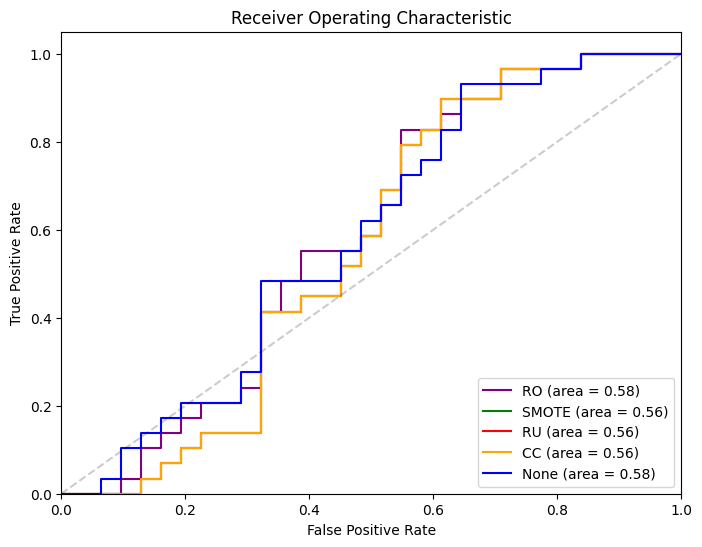

In [15]:
plt.figure(figsize=(8, 6))
colour_idx = 0
colours = ['purple', 'green', 'red','orange','blue']

for name, (best_band,estimator, filter_b_a, best_W) in freqBandEstimators.items():
    probs = cross_val_predict(estimator, testData_motionIntent.iloc[:,:nCols-1], testData_motionIntent.iloc[:,nCols-1], cv=5, method="predict_proba")
    probs = probs[:, 1]  # use the probability of the positive class
    true_labels = testData_motionIntent.iloc[:,nCols-1]

    # Calculate ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(true_labels, probs)
    auc_score = auc(fpr, tpr)

    # Plot ROC curve for current model
    plt.plot(fpr, tpr, color=colours[colour_idx], label= name + ' (area = %0.2f)' % auc_score)
    colour_idx += 1

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"{name} resampler optimal threshold : {optimal_threshold}")

plt.plot([0, 1], [0, 1], 'k--',alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [16]:
_, bestEstimator_freq_band, (best_b,best_a), W_freq_band = freqBandEstimators["None"]


### Person's Correlation Coefficient (PCC) + CSP

In [17]:
# #Plot distributions of channels against eachother
# # to find out if there is any sort of positive correlation
# # between channels

# import seaborn as sns
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# trialWin = np.arange(int(0*sRate),int(4*sRate))

# # #get mixed trial data from original
# trials_mixed = np.zeros(
#             (nChannels, len(eventOnsets[0]), len(trialWin)))


# for i, onset in enumerate(eventOnsets[0]):
#     trials_mixed[:,i,:] = eeg[:,onset+trialWin]

# # By augmenting the algorithm outlined in [ref: Electroencephalogram channel selection based on pearson correlation coefficient for motor imagery-brain-computer interface]
# # we can able to extract the most correlated channels in the given data prior to selecting features with the CSP algorithm.


# scaler = StandardScaler()

# # For each trial
# #We must standardize the values in each trial window for each channel (We use z-score normalization for this)
# _, nTrials, _ = trials_mixed.shape

# trialChannelCorrelations = []

# plotFirst = False #flag to check that heatmap of first trial is plotted

# for trial in range(nTrials):

#     zTrial = scaler.fit_transform(trials_mixed[:,trial,:])
#     corrMat = np.corrcoef(zTrial)

#     if not plotFirst:
#         plt.figure(figsize=(15, 16))
#         sns.heatmap(pd.DataFrame(corrMat,columns=channelNames,index=channelNames),cmap="RdYlGn",vmin=-1,vmax=1)
#         plotFirst = True

# #     # We must then calculate the correlation matrices for each trial and return the mean for each row, giving us a vector of mean values
# #     # which represents the average corellation values for a specific channel in relation to other channels.
#     channelCorrValues = {ch:corrMean for (ch,corrMean) in zip(channelNames,np.mean(corrMat,axis=1))}

# #     #Following the above referenced paper, we select the first 14 channels

#     channelCorrValues = dict(sorted(channelCorrValues.items(), key=lambda x:x[1], reverse=True)[:14])
#     trialChannelCorrelations.append(channelCorrValues)


In [18]:
# from collections import defaultdict

# channelOccurences = defaultdict(int)

# for dic in trialChannelCorrelations:
#     for ch, _ in dic.items():
#         channelOccurences[ch] += 1


# # This represent the most correlated channels ordered (descending) by the number of time they appear
# # in the most correlated channel list for each trial
# channelOccurences = dict(sorted(channelOccurences.items(), key=lambda x:x[1], reverse=True))

# selectedChannels = list(channelOccurences.keys())[:32]
# # #It can be seen that all selected channels are in and around the sensorimotor cortex

# selectedSet = set(selectedChannels)
# selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

# # #Plot heatmap of first trial
# plt.figure(figsize=(10, 8))
# sns.heatmap(pd.DataFrame(np.corrcoef(scaler.fit_transform(trials_mixed[selectedIdxs,0,:])),
#             columns=selectedChannels,
#             index=selectedChannels),
#             cmap="RdYlGn",
#             vmin=-1,
#             vmax=1)


In [19]:
# channelNums = dict()

# for i in range(2,nChannels+1):
#     selectedChannels = list(channelOccurences.keys())[:i]
#     #It can be seen that all selected channels are in and around the sensorimotor cortex

#     selectedSet = set(selectedChannels)
#     selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

#     accVal = 0
#     bestAccVal = 0
#     bestEstimator_selected_channels = None
#     for model in ["Logistic Regression","LDA","SVC"]:
#         accVal, estimator, W =  testClassifier(dataA,0,4,0.7,model,b=best_b,a=best_a,selectedChannels=selectedIdxs)

#         if accVal > bestAccVal:
#             bestAccVal = accVal
#             bestEstimator_selected_channels = estimator

#     channelNums[i] = bestAccVal


In [20]:
# bestEstimator_selected_channels

In [21]:
# probs = cross_val_predict(bestEstimator_selected_channels,testData_motionIntent.iloc[:,:nCols-1], testData_motionIntent.iloc[:,nCols-1],cv=5, method="predict_proba")
# probs = probs[:, 1]  # use the probability of the positive class
# true_labels = testData_motionIntent.iloc[:,nCols-1]

# # Calculate ROC curve and AUC score
# fpr, tpr, thresholds = roc_curve(true_labels, probs)
# auc_score = auc(fpr, tpr)

# # Plot ROC curve
# plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.show()


In [22]:
# bestY = 0
# for x, y in channelNums.items():
#     bestY= max(bestY,y)
#     plt.bar(x,y)

# plt.xlabel("First N selected channels")
# plt.ylabel("Accuracy")
# plt.axhline(y=bestY, color='black', ls='--', lw=1.5, label=f"Best performance({bestY})")
# plt.legend(loc='lower right')


### Calibration of best classifier to predict probability outputs for all time samples

In [23]:
evalDataA = scipy.io.loadmat("BCICIV_1eval_1000Hz_mat/BCICIV_eval_ds1a_1000Hz.mat")


In [24]:
bestEstimator_freq_band

LogisticRegression(C=0.49417133613238334, solver='liblinear')

In [25]:
idlesStateClassifier


LogisticRegression(C=0.1206792640639329, class_weight='balanced',
                   solver='liblinear')

In [26]:

from sklearn.calibration import CalibratedClassifierCV

bestEstimator_freq_band = CalibratedClassifierCV(bestEstimator_freq_band,cv="prefit")
bestEstimator_freq_band.fit(testData_motionIntent.iloc[:,:nCols-1], testData_motionIntent.iloc[:,nCols-1])

CalibratedClassifierCV(cv='prefit',
                       estimator=LogisticRegression(C=0.49417133613238334,
                                                    solver='liblinear'))

#### Calibrate SVC

In [27]:
probabilities = startRunningClassifier(evalDataA,bestEstimator_freq_band,idlesStateClassifier,comp,W_freq_band,W_idle_motionIntent,trialWinStart=0,trialWinEnd=4,b=best_b,a=best_a)


In [29]:
import csv

with open("output_subject_a_1000Hz.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(probabilities)
